In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import re
import sys
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from dateutil.rrule import *
from zipfile import ZipFile
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

####Data Loading and Transformation

In [4]:
# df = spark.read.csv('/FileStore/tables/UScovid.csv',header=True)
# covid_global = df.toPandas()
# covid_global['country'] = 'USA'

# covid_global = covid_global[['date','recovered','country']]
# covid_global.columns = ['variable','value','country']

# covid_global['Date'] = pd.to_datetime(covid_global['variable'])
# covid_global['value'] = covid_global['value'].astype('float')
# covid_global = covid_global[covid_global['value']>0]
# covid_global.drop(['variable'],axis=1,inplace=True)

# def preprocess_data_uk(url, country_name):
#   df = fetch_data(url)
#   df = df.fillna(100)
#   df = df[(df['Country/Region']=='United Kingdom') & (df['Province/State']==100)]

#   df = df.drop(['Unnamed: 0', 'Province/State', 'Lat', 'Long'],axis=1)
#   df = df.rename(columns={'Country/Region':'country'})
#   df = df[df['country'].str.contains(country_name)]
#   df = df.melt(id_vars=['country'], value_vars=df.columns[1:])
  
#   result = df[df['country'].str.contains(country_name)][['variable','value','country']]
#   result['Date'] = pd.to_datetime(result['variable'])
#   result.drop(['variable'],axis=1,inplace=True)
#   result = result.groupby(['Date','country']).sum()['value']
#   result = result.reset_index()
#   result = result[result['value']>0]
#   result['value'] = result['value'].astype('float')

#   return result[['Date','value','country']]

In [5]:
def fetch_data(url):
  return pd.read_html(url,header=[0])[0]

def preprocess_data(url, country_name):
  df = fetch_data(url)
  df = df.drop(['Unnamed: 0', 'Province/State','Lat','Long'],axis=1)
  df = df.rename(columns={'Country/Region':'country'})
  df = df.melt(id_vars=['country'], value_vars=df.columns[1:])
  
  result = df[df['country'].str.contains(country_name)][['variable','value','country']]
  result['Date'] = pd.to_datetime(result['variable'])
  result.drop(['variable'],axis=1,inplace=True)
  result = result.groupby(['Date','country']).sum()['value']
  result = result.reset_index()
  result = result[result['value']>0]
  result['value'] = result['value'].astype('float')

  return result[['Date','value','country']]  

In [6]:
### Code for direct reading csv file from github and processing for China,India,Singapore,Sweden,UK,USA
base_url = 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/'
ext_url = 'time_series_covid19_{}.csv'

data_type = ['confirmed_global','deaths_global','recovered_global']

# Define country name for which data forcasting to be done
country_name = 'India'

covid_data = preprocess_data(base_url+ext_url.format(data_type[0]),country_name)

In [7]:
##this csv file will be used in R for creating model and prediction
rdata = covid_data.copy()
rdata.to_csv('../../tmp/Rserv/covid_today.csv',index=False)

####Data Visualisation

In [9]:
display(spark.createDataFrame(rdata))

Date,value,country
2020-01-30T00:00:00.000+0000,1.0,India
2020-01-31T00:00:00.000+0000,1.0,India
2020-02-01T00:00:00.000+0000,1.0,India
2020-02-02T00:00:00.000+0000,2.0,India
2020-02-03T00:00:00.000+0000,3.0,India
2020-02-04T00:00:00.000+0000,3.0,India
2020-02-05T00:00:00.000+0000,3.0,India
2020-02-06T00:00:00.000+0000,3.0,India
2020-02-07T00:00:00.000+0000,3.0,India
2020-02-08T00:00:00.000+0000,3.0,India


####Statistic Test to Check Data Stationary

In [11]:
###Check stationarity with differencing
dataset = covid_data['value'].astype('float').values
dataset_diff = np.diff(dataset, n=3)

In [12]:
##KPSS test for trend stationarity
def stationary_test_using_kpss(tsData):    
    statistic, p_value, n_lags, critical_values = kpss(tsData)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

stationary_test_using_kpss(dataset_diff)

KPSS Statistic: 0.07857022279373192
p-value: 0.1
num lags: 12
Critial Values:
 10% : 0.347
 5% : 0.463
 2.5% : 0.574
 1% : 0.739
Result: The series is stationary

In [13]:
##Dickey-Fuller unit root test for trend stationarity
def stationarity_test_using_adfuller(tsData):
    test = adfuller(tsData)
    results = pd.Series(test[0:4], index=['ADFULLER Statistic','p-value','num lags','Number of Observations Used'])
    p_value = test[1]
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    
    print(results)
    print(f'Result: The series is {"not " if p_value > 0.05 else ""}stationary')

stationarity_test_using_adfuller(dataset_diff)

ADFULLER Statistic -3.794431
p-value 0.002965
num lags 11.000000
Number of Observations Used 77.000000
Critical Value (1%) -3.518281
Critical Value (5%) -2.899878
Critical Value (10%) -2.587223
dtype: float64
Result: The series is stationary

####Forecast Model Building in R

In [15]:
%r
data <- read.csv('../covid_today.csv')

In [16]:
%r
library(lubridate)
library(fUnitRoots)
library(lmtest)
library(forecast)
library(FitAR)

tsData = ts(data[2], start = decimal_date(as.Date("2020-01-22")), frequency = 365)

####Determining P and Q values for ARIMA

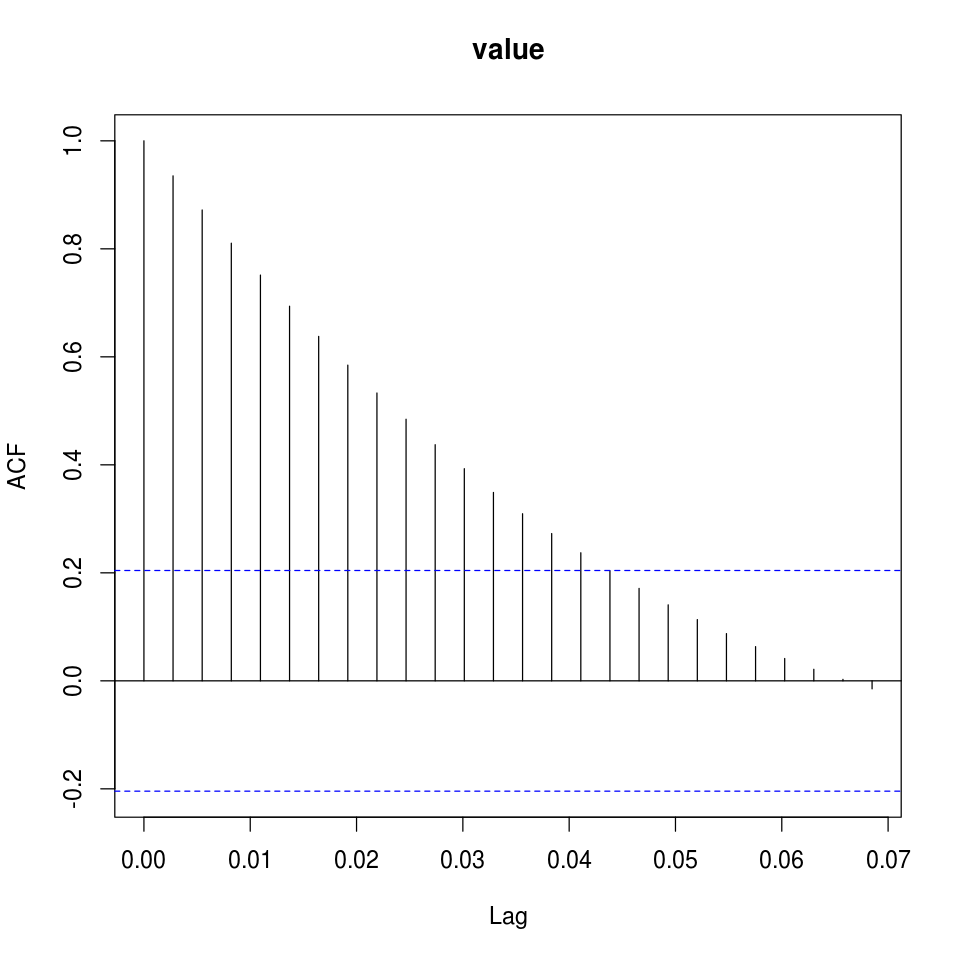

In [18]:
%r
acf(tsData, lag.max=25)

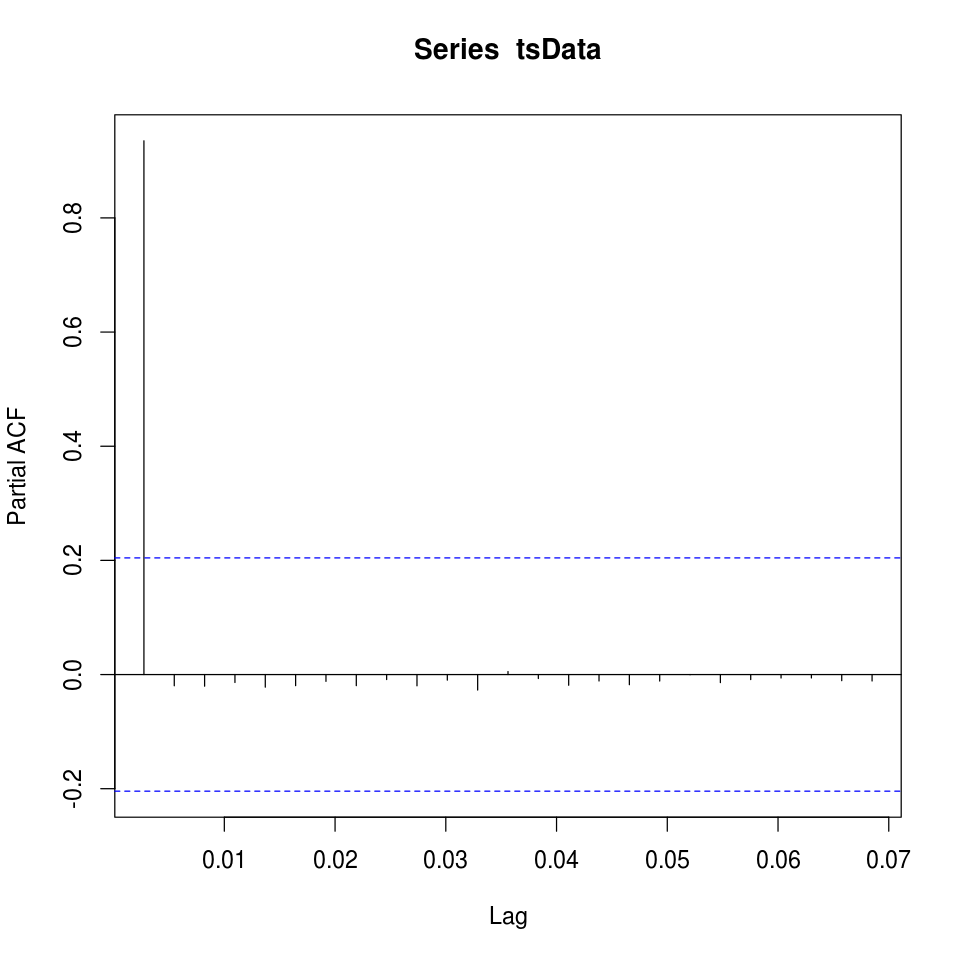

In [19]:
%r
pacf(tsData, lag.max=25)

In [20]:
%r
###Arima with manual calculation of p,d,q values
p=7
d=3
q=1
fitARIMA <- arima(tsData, order=c(p,d,q),method="ML",)

In [21]:
%r
print(fitARIMA)

print("***********************************")
print("******Print Accuracy of Model******")
print("***********************************")

print(accuracy(fitARIMA))

Call:
arima(x = tsData, order = c(p, d, q), method = "ML")

Coefficients:
 ar1 ar2 ar3 ar4 ar5 ar6 ar7 ma1
 -1.3739 -1.5171 -1.5543 -1.3059 -0.7926 -0.4578 -0.1481 -0.6888
s.e. 0.1612 0.2892 0.3713 0.3912 0.3456 0.2435 0.1303 0.1356

sigma^2 estimated as 20486: log likelihood = -571.28, aic = 1160.56
[1] "***********************************"
[1] "******Print Accuracy of Model******"
[1] "***********************************"
 ME RMSE MAE MPE MAPE MASE ACF1
Training set 12.23801 140.7756 64.41213 2.28874 6.66471 0.1681345 -0.04337915

####Model Good Fit Test

In [23]:
%r
k = p+q
Box.test(fitARIMA$residuals, lag = 10, type = c("Ljung-Box"), fitdf=k)

Box-Ljung test

data: fitARIMA$residuals
X-squared = 5.5182, df = 2, p-value = 0.06335

####Auto Arima in Case of Data Abnormalities

In [25]:
# %r
# ###Auto Arima will decide p,d,q values internally

# fitARIMA <- auto.arima(tsData, trace=TRUE)

# print(fitARIMA)

# # print("***********************************")
# # print("******Print Accuracy of Model******")
# # print("***********************************")

# print(accuracy(fitARIMA))

####Model Residuals Analysis Plot

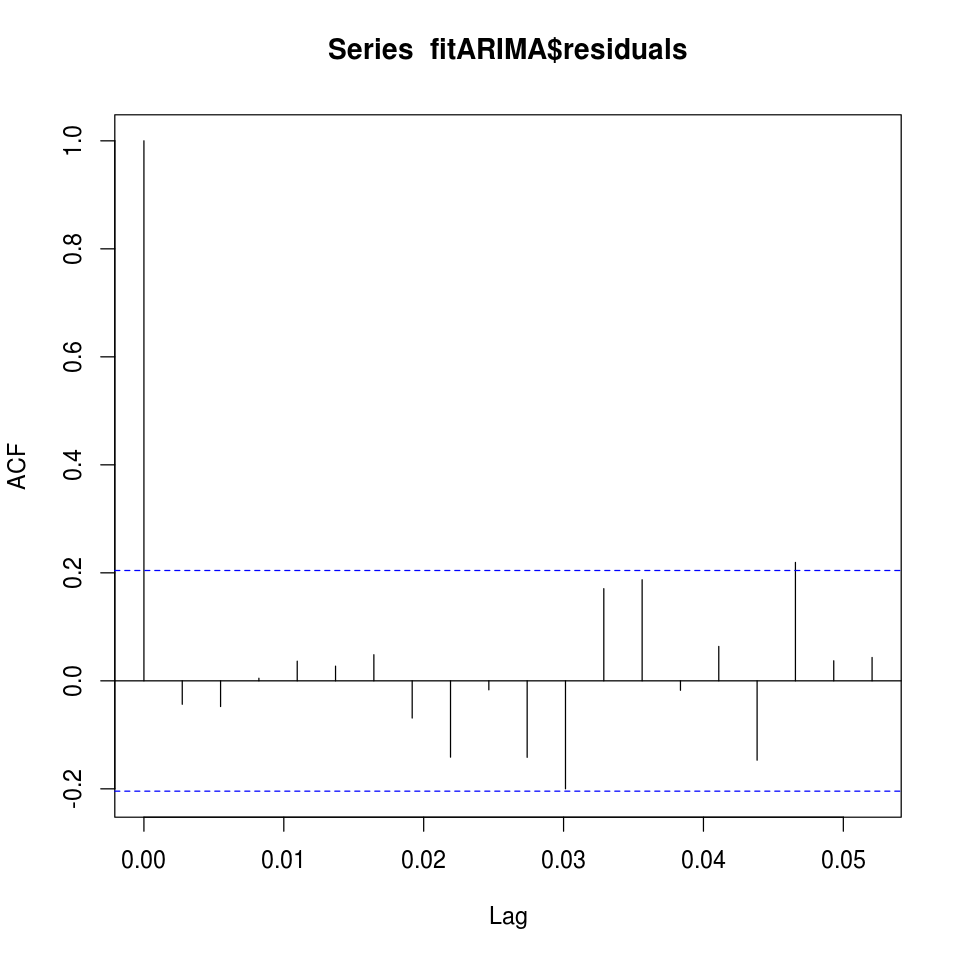

In [27]:
%r
acf(fitARIMA$residuals)

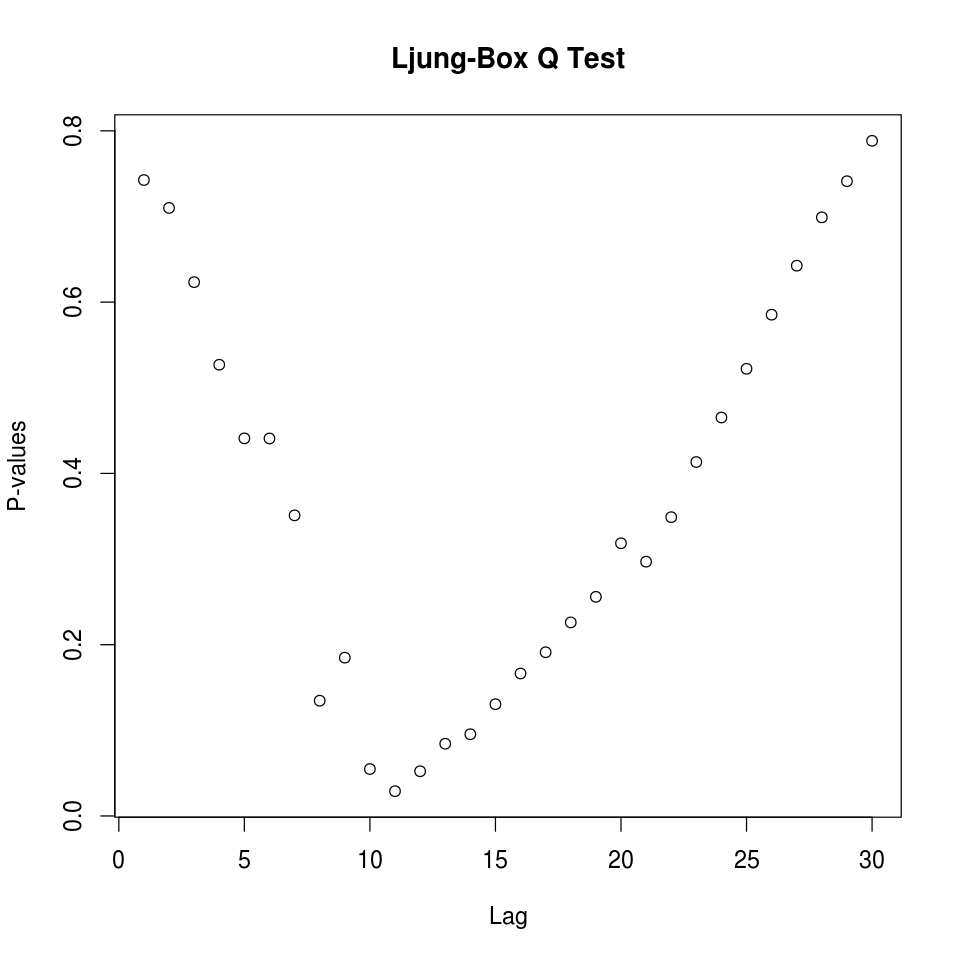

In [28]:
%r
plot(boxresult[,3],main= "Ljung-Box Q Test", ylab= "P-values", xlab= "Lag")

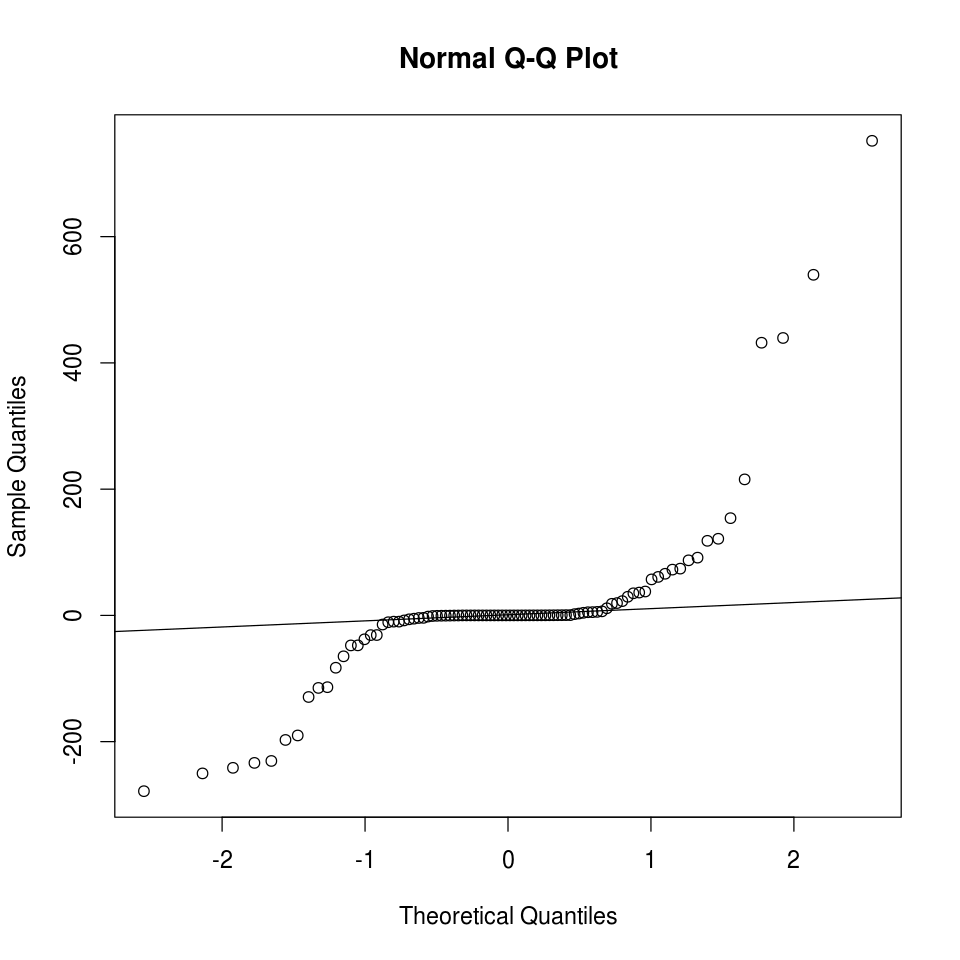

In [29]:
%r
qqnorm(fitARIMA$residuals)
qqline(fitARIMA$residuals)

####Predicting Future Values

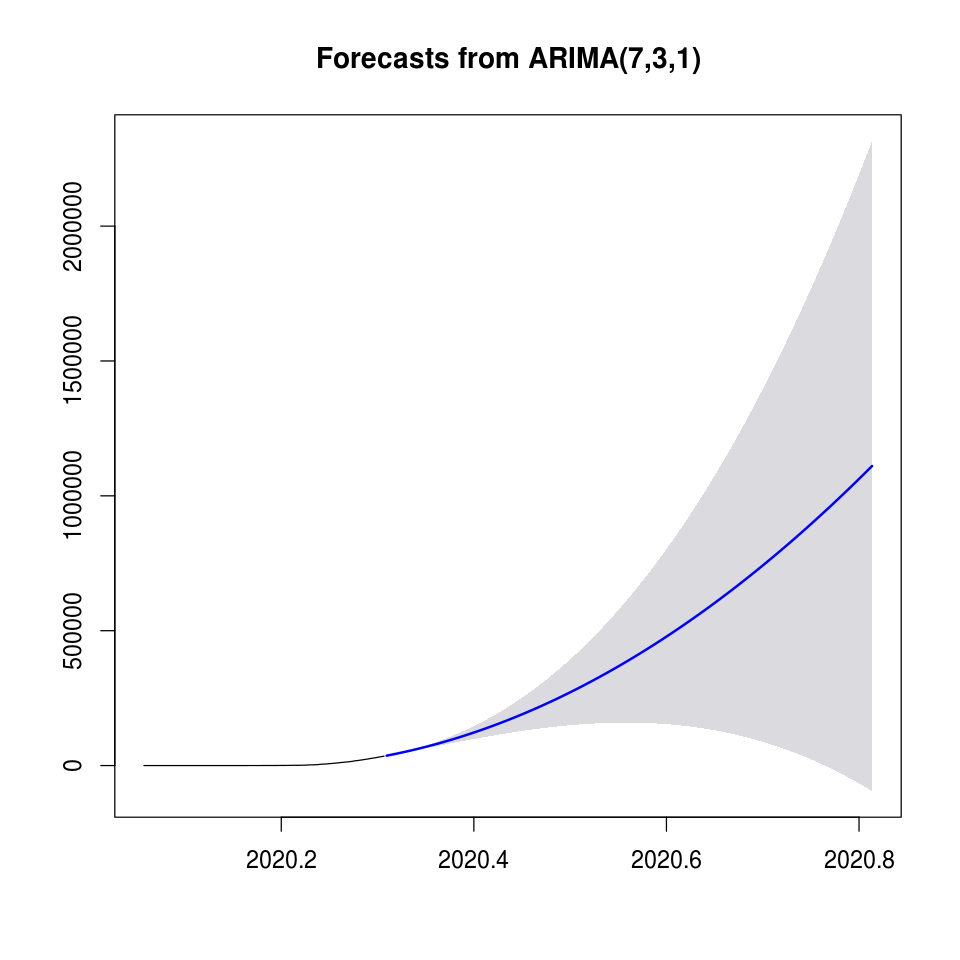

In [31]:
%r
futurVal <- forecast(fitARIMA,h=185, level=c(95))
plot(futurVal)

In [32]:
%r
write.csv(futurVal, '../../../databricks/driver/future.csv')

In [33]:
data_ind = rdata.set_index('Date')
startdate = data_ind.index[-1].date() + dt.timedelta(days=1)
futureDates = pd.DataFrame(list(rrule(DAILY,count=185,dtstart=startdate)),columns=['Date'])

future_val_pd = pd.read_csv('future.csv')
future_val_new = futureDates.merge(future_val_pd,left_index=True, right_index=True)
future_val_new.drop(['Unnamed: 0', 'Lo.95', 'Hi.95'],axis=1, inplace=True)
future_val_new['country'] = '{}_Forecasted'.format(country_name)
future_val_new.columns = rdata.columns
df_temp = rdata.append(future_val_new)

In [34]:
df_temp[df_temp['Date'].isin(['2020-06-01','2020-07-01','2020-10-01'])]

,Date,value,country
31,2020-06-01,115717.768854,India_Forecasted
61,2020-07-01,231491.558383,India_Forecasted
153,2020-10-01,827772.671497,India_Forecasted


In [35]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,5))
sns.lineplot(x='Date', y='value', data=df_temp, hue='country')